# Disentangling quarks and gluons

This notebook roughly corresponds to section 3 of our paper. (Feel free to clean up any of the code in here as needed, or ask me if anything seems confusing.)

To start, we need to load in the data file. We assume the data is formatted the same way that Patrick originally gave it to me. (If you'd like, we can add in the preprocessing code for that as well -- for now, I'll assume that you have a .npz file lying around somewhere.)

In [60]:
%load_ext autoreload
%autoreload 2

# General settings to make plotting look nice
import matplotlib.font_manager
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'cm'
rcParams['text.usetex'] = True
# rcParams['font.family'] = 'serif'
# rcParams['font.serif'] = ['CMU Serif']
hops = {'histtype': 'step', 'density': True}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
import pandas as pd
import numpy as np
import h5py as hd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

import loader, solver


(3, 3, 60, 60)


/Users/nilai/phys/hep/qcqp/code/loader.py:303: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


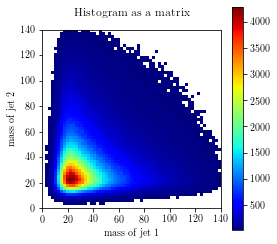

In [62]:
# For now, we only support mass, multiplicity, n95, and n-subjettiness
# although, adding another variable is very simple, that's all we provide in copy.npz

var_name = "mass"
L = loader.QGLoader(file_name="../data/copy.npz", var_name=var_name)
L.get_histograms_binned(symmetric=True)

# Default: 3 bins in eta, 60 bins in mass
print(L.histograms.shape)
L.plot_histogram_sample()

In [63]:
# We provide a couple of types of solvers for the unbinned case, 
# but if we use rapidity bins, only 
# the one based on cvxpy works (solve_slow_binned).

# As all the solvers are asymmetric, we're solving the problem:
#    min_{W, H_i} sum_i || D_i - WH_i^T||_F 
#    s.t. W > 0, H_i > 0
# where {i} indexes over the bins in rapidity-space.
# Therefore, there is no constraint that H = W. We will recover
# the mixing matrices separately, see below.

# I suggest n_iter ~ 15, at most, and for best results, k=9.
# Note that this will take >2 hours though, so for demo we set k=3

W, H, losses = solver.solve_slow_binned(L.histograms, k=3, n_iter=5)

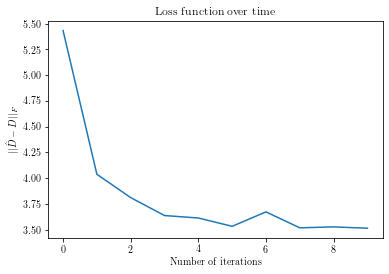

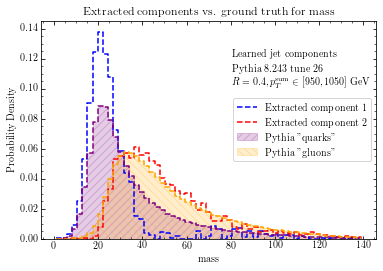

In [64]:
# Now we will generate plots comparing the extracted topics with the ground truth

plt.plot(range(len(losses)), np.log10(losses))
plt.title("Loss function over time")
plt.xlabel("Number of iterations")
plt.ylabel("$||\hat{D} - D ||_{F}$")
plt.show()

colors=["blue", "red"]
labels=["Component 1", "Component 2"]
plt.figure(figsize=(6,4))

# Need to get the ground truth labels, and normalize the components extracted
W_normalized = []
W_true = []
for i in range(L.n_labels):
    w_extracted = W[:,i]
    # Sometimes you get floating point errors where a value is < 0
    w_extracted[w_extracted < 0] = 0
    W_normalized.append(w_extracted)
W_normalized = np.array(W_normalized).T

# For this section, we're rolling with k=2
bins = (L.bins[1:] + L.bins[:-1])/2.

# Plot the extracted components
# Please note that here, we do *not* need to perform any 
# subtraction due to mutual reducibility of the components.
plt.plot(bins, W_normalized[:,0]/sum(W_normalized[:, 0]), linestyle='--',
         color="blue", label="Extracted component 1", drawstyle="steps-post")
plt.plot(bins, W_normalized[:,1]/sum(W_normalized[:, 1]), linestyle='--',
         color="red",  label="Extracted component 2", drawstyle="steps-post")

# Plot the ground truth components
true_hist_0, _ = np.histogram(L.var[L.labels == 0], bins=L.bins)
true_hist_1, _ = np.histogram(L.var[L.labels == 1], bins=L.bins)

plt.plot(bins, true_hist_0/sum(true_hist_0), linestyle='--',
         color="purple", drawstyle="steps-post")
plt.plot(bins, true_hist_1/sum(true_hist_1), linestyle='--',
         color="orange", drawstyle="steps-post")
plt.fill_between(bins, true_hist_0/sum(true_hist_0), color='purple', hatch='///',
                 label="Pythia \"quarks\"", alpha=0.2, step="post")
plt.fill_between(bins, true_hist_1/sum(true_hist_1), color='orange', hatch='\\\\\\',
                 label="Pythia \"gluons\"", alpha=0.2, step="post")
ax = plt.gca()
ax.set_ylim(bottom=0.)
ax.minorticks_on()
ax.tick_params(top=True, right=True, bottom=True, left=True, direction='in', which='both')
plt.xlabel("{0}".format(var_name))
plt.ylabel("Probability Density")
plt.title("Extracted components vs. ground truth for {0}".format(var_name))
text = ["Learned jet components", "Pythia 8.243 tune 26", "$R = 0.4, p_T^{\mathrm{sum}} \in [950, 1050]$ GeV"]
for i, s in enumerate(text):
    if i == 0:
        plt.text(0.57, 0.85-0.07*i, s, ha='left', va='center', transform=ax.transAxes, fontweight="bold") 
    else:
        plt.text(0.57, 0.85-0.07*i, s, ha='left', va='center', transform=ax.transAxes) 

plt.legend(loc="center right")
plt.savefig("figs/{0}.pdf".format(var_name),bbox_inches='tight')
plt.show()

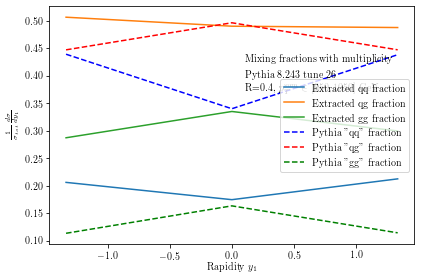

In [70]:
# To recover the (implied) mixing matrices corresponding to our
# learned topics, we simply solve the problem
#    min_{F_i} || D - W(F_i)W^T ||_F 
#    s.t. sum(F_i) == 1
# which is convex in each F_i, again i indexing the bins.
# Note, this is complete garbage if n_quantiles < 5.
# Reason: 
# -(Approximate) superfactorization means that there is (approximate) non-identifiability in the solution
# -This means that there are solutions that are "close" in loss, but far away in ||W - W_true||_F
# -Couple with our method guaranteeing only a local optimum, and you can get a bad solution
# To avoid this, binning in auxiliary variable can help, although there is still stochasticity

learned_mixing_matrices = L.retrieve_learned_mixing_matrices(W)

pred_sum = learned_mixing_matrices.mean(axis=0)
true_sum = L.mixing_matrices.mean(axis=0)

n_q = L.n_quantile
q_indices = np.linspace(-2, 2, n_q+1)
bins_q = (q_indices[:-1]+q_indices[1:])/2.

plt.plot(bins_q, [a[0][0] for a in pred_sum], label="Extracted qq fraction")
plt.plot(bins_q, [a[0][1]+a[1][0] for a in pred_sum],label="Extracted qg fraction")
plt.plot(bins_q, [a[1][1] for a in pred_sum],label="Extracted gg fraction")

plt.plot(bins_q, [a[0][0] for a in true_sum], color='blue', linestyle="--", label="Pythia \"qq\" fraction")
plt.plot(bins_q, [a[0][1]+a[1][0] for a in true_sum], color='red', linestyle="--", label="Pythia \"qg\" fraction")
plt.plot(bins_q, [a[1][1] for a in true_sum], color='green', linestyle="--", label="Pythia \"gg\" fraction")

text = [
    "Mixing fractions with multiplicity",
    "Pythia 8.243 tune 26",
    "R=0.4, $p_T^{\mathrm{sum}} \in [950, 1050]$ GeV"
]

for i, s in enumerate(text):
    if i == 0:
        plt.text(0.57, 0.85-0.07*i, s, ha='left', va='center', transform=ax.transAxes, fontweight="bold") 
    else:
        plt.text(0.57, 0.85-0.07*i, s, ha='left', va='center', transform=ax.transAxes) 
        
plt.ylabel("$\\frac{1}{\sigma_{tot}}\\frac{d\sigma}{dy_1}$")
plt.xlabel("Rapidity $y_1$")
plt.legend()
plt.tight_layout()
plt.savefig("figs/mixing_fracs.pdf",bbox_inches='tight')
plt.show()